# DQAN (Deep Q-Adverserial Nets): DQN (Deep Q-Nets) + GAN (Gen. Adv. Nets)

In this notebook, we'll combine a DQN (deep Q-net) with GAN (generative adverserial net) that can learn to play games through reinforcement learning without any reward function. We'll call this network DQAN (deep Q adverserial net). 
Adverserial nets learn to maximize the current reward based the past rewards.
Q-net learns to maximize the future rewards based on the current reward.
Given a task and known when the task is done or failed, we should be able to learn the task.

# DQN
More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    print('state, action, reward, done, info')
    print(state, action, reward, done, info)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

state, action, reward, done, info
[-6.10042299e-03 -1.71261127e-01 -1.11377864e-04  2.65194181e-01] 0 1.0 False {}
state, action, reward, done, info
[-0.00952565  0.02386241  0.00519251 -0.02752387] 1 1.0 False {}
state, action, reward, done, info
[-0.0090484   0.21890952  0.00464203 -0.31856399] 1 1.0 False {}
state, action, reward, done, info
[-0.00467021  0.02372176 -0.00172925 -0.02442076] 0 1.0 False {}
state, action, reward, done, info
[-0.00419577  0.21886847 -0.00221767 -0.31764879] 1 1.0 False {}
state, action, reward, done, info
[ 1.81597700e-04  4.14021936e-01 -8.57064259e-03 -6.11030261e-01] 1 1.0 False {}
state, action, reward, done, info
[ 0.00846204  0.60926263 -0.02079125 -0.90640028] 1 1.0 False {}
state, action, reward, done, info
[ 0.02064729  0.80465982 -0.03891925 -1.20554492] 1 1.0 False {}
state, action, reward, done, info
[ 0.03674049  1.00026253 -0.06303015 -1.51016617] 1 1.0 False {}
state, action, reward, done, info
[ 0.05674574  1.19608904 -0.09323348 -1.821

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
1 0
2
1.0 1.0
1.1960890396872554 -1.8218412331768141


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [5]:
def model_input(state_size):
    # Given data
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Actions as output
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # Target Q values for training
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return states, next_states, actions, targetQs

In [6]:
# tf.layers.dense(
#     inputs, ????????????????????????
#     units, ??????????????????????
#     activation=None,
#     use_bias=True, OOOOOOOOOOOOOOOOOOOOOOOK
#     kernel_initializer=None,
#     bias_initializer=tf.zeros_initializer(), OOOOOOOOOOOOOOOK
#     kernel_regularizer=None,
#     bias_regularizer=None,
#     activity_regularizer=None,
#     kernel_constraint=None,
#     bias_constraint=None,
#     trainable=True, ??????????????????
#     name=None,
#     reuse=None
# )

In [39]:
# Q function
def generator(states, state_size, action_size, hidden_size, reuse=False, alpha=0.1): #training=True ~ batchnorm
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=training) #training=True ~ batchnorm
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=training) #training=True ~ batchnorm
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits_actions = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits_actions)

        # Output layer
        logits_next_states = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)        
        #predictions = tf.nn.softmax(logits_next_states)

        # # Output layer
        # logits = tf.layers.dense(inputs=nl2, units=(state_size + action_size))

        # # Split the states and actions (opposite of fusion)
        # logits_next_states, logits_actions = tf.split(value=logits, axis=1, num_or_size_splits=[state_size, action_size])

        return logits_actions, logits_next_states

In [40]:
# This is a reward function: Rt(St+1, at) or Rt(~St+1, ~at)
def discriminator(next_states, actions, hidden_size, reuse=False, alpha=0.1): #training=True ~ batchnorm
    with tf.variable_scope('discriminator', reuse=reuse):
        # Stack/concatenate/fuse actions and states or 
        # predicted/reconstructed actions and states
        x_fused = tf.concat(values=(next_states, actions), axis=1)
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=True)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=True)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)   
        #predictions = tf.sigmoid(logits)

        # logits for loss and reward/prob/out
        return logits

In [41]:
# Qt(St, At) = Rt(St+1, At) + max(alpha*Qt+1(St+1))
def model_loss(states, next_states, state_size, actions, action_size, hidden_size, targetQs, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param states: real current input states or observations given
    :param actions: real actions given
    :return: A tuple of (discriminator loss, generator loss)
    """
    # The fake/generated actions
    actions_logits, next_states_logits = generator(states=states, state_size=state_size, hidden_size=hidden_size, 
                                              action_size=action_size)
    #print(actions_logits.shape, next_states_logits.shape)
    actions_fake = tf.nn.softmax(actions_logits)
    next_states_fake = tf.sigmoid(x=next_states_logits)
    d_logits_fake = discriminator(next_states=next_states_fake, actions=actions_fake, hidden_size=hidden_size, reuse=False)

    # The real onehot encoded actions
    actions_real = tf.one_hot(actions, action_size)
    next_states_real = tf.sigmoid(x=next_states) 
    d_logits_real = discriminator(next_states=next_states_real, actions=actions_real, hidden_size=hidden_size, reuse=True)

    # Training the rewarding function
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    # Train the generate to maximize the current reward 0-1
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    # Train the generator to maximize the future rewards: Bellman equations: loss (targetQ - Q)^2
    Qs = tf.reduce_sum(tf.multiply(actions_logits, actions_real), axis=1)
    q_loss = tf.reduce_mean(tf.square(targetQs - Qs))

    # The generated rewards for Bellman equation
    rewards_fake = tf.sigmoid(d_logits_fake)
    rewards_real = tf.sigmoid(d_logits_real)

    return d_loss, g_loss, q_loss, actions_logits, Qs, rewards_fake, rewards_real

In [42]:
def model_opt(d_loss, g_loss, q_loss, learning_rate):
    """
    Get optimization operations
    :param d_loss: Discriminator/Reward loss Tensor for reward function
    :param g_loss: Generator/Q-value loss Tensor for action & next state predicton
    :param q_loss: Value loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=g_vars)

    return d_opt, g_opt, q_opt

In [43]:
class DQAN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.next_states, self.actions, self.targetQs = model_input(state_size=state_size)
        #print(self.states, self.next_states, self.actions, self.targetQs)

        # Create the Model: calculating the loss and forwad pass
        self.d_loss, self.g_loss, self.q_loss, self.actions_logits, self.Qs, self.rewards_fake, self.rewards_real = model_loss(
            state_size=state_size, action_size=action_size, actions=self.actions, 
            states=self.states, next_states=self.next_states, 
            hidden_size=hidden_size, targetQs=self.targetQs)

        # Update the model: backward pass and backprop
        self.d_opt, self.g_opt, self.q_opt = model_opt(d_loss=self.d_loss, g_loss=self.g_loss, 
                                                       q_loss=self.q_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [44]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [45]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200               # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64              # number of units in each Q-network hidden layer -- simulation
state_size = 4                # number of units for the input state/observation -- simulation
action_size = 2               # number of units for the output actions -- simulation

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 10                # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [46]:
tf.reset_default_graph()
model = DQAN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, 
                 learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [47]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [48]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list = []
d_loss_list, g_loss_list, q_loss_list = [], [], [] 
rewards_fake_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward = 0
        d_loss, g_loss, q_loss = 0, 0, 0
        rewards_fake_mean = 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Average reward fake: {}'.format(rewards_fake_mean),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                rewards_fake_list.append((ep, rewards_fake_mean))
                d_loss_list.append((ep, d_loss))
                g_loss_list.append((ep, g_loss))
                q_loss_list.append((ep, q_loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train the model
            # feed_dict={model.states: next_states}
            # next_actions_logits, next_rewards_fake = sess.run([model.actions_logits, model.rewards_fake], feed_dict)
            feed_dict = {model.states: states}
            rewards_fake = sess.run(model.rewards_fake, feed_dict)
            feed_dict={model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)

            # Mean/average fake rewards or rewarded generated actions
            rewards_fake_mean = np.mean(rewards_fake.reshape(-1))
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_actions_logits[episode_ends] = (0, 0)

            # Bellman equation: Qt = Rt + max(Qt+1)
            targetQs = rewards_fake.reshape(-1) + (gamma * np.max(next_actions_logits, axis=1))
            # print('DEBUGGING', targetQs.shape, next_rewards_fake.shape, next_actions_logits.shape, np.max(next_actions_logits, axis=1).shape)

            # Updating the model
            # print(states.shape, next_states.shape, targetQs.shape, actions.shape)
            feed_dict = {model.states: states, model.next_states: next_states, model.actions: actions, model.targetQs: targetQs}
            #states, next_states, actions, Qs = sess.run([model.states, model.next_states, model.actions, model.Qs], feed_dict)
            #print(states.shape, next_states.shape, actions.shape, Qs.shape)
            #rewards_real = sess.run(model.rewards_real, feed_dict)
            #d_loss = sess.run(model.d_loss, feed_dict)
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            
    # Save the trained model 
    saver.save(sess, 'checkpoints/DQAN-cartpole.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 10.0 Average reward fake: 0.48005765676498413 Training d_loss: 1.3099 Training g_loss: 0.7401 Training q_loss: 0.4127 Explore P: 0.9990
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 18.0 Average reward fake: 0.4778939187526703 Training d_loss: 1.2042 Training g_loss: 0.7468 Training q_loss: 0.4495 Explore P: 0.9972
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 11.0 Average reward fake: 0.49697789549827576 Training d_loss: 1.3116 Training g_loss: 0.7172 Training q_loss: 1.7709 Explore P: 0.9961
-------------------------------------------------------------------------------
--------------------------------------

-------------------------------------------------------------------------------
Episode: 26 Total reward: 20.0 Average reward fake: 0.032715048640966415 Training d_loss: 0.0934 Training g_loss: 5.3382 Training q_loss: 18815.4727 Explore P: 0.9423
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 27 Total reward: 10.0 Average reward fake: 0.034544918686151505 Training d_loss: 0.0856 Training g_loss: 3.4841 Training q_loss: 17557.1973 Explore P: 0.9414
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 28 Total reward: 22.0 Average reward fake: 0.012021704576909542 Training d_loss: 0.0269 Training g_loss: 4.4737 Training q_loss: 143545.2812 Explore P: 0.9394
-------------------------------------------------------------------------------
------------------

-------------------------------------------------------------------------------
Episode: 51 Total reward: 23.0 Average reward fake: 0.0007540752412751317 Training d_loss: 0.0018 Training g_loss: 7.1965 Training q_loss: 180196.0938 Explore P: 0.9005
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 52 Total reward: 18.0 Average reward fake: 0.0006361400010064244 Training d_loss: 0.0013 Training g_loss: 7.3719 Training q_loss: 115112.0469 Explore P: 0.8989
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 53 Total reward: 23.0 Average reward fake: 0.0006066871574148536 Training d_loss: 0.0011 Training g_loss: 7.4031 Training q_loss: 158798.9688 Explore P: 0.8969
-------------------------------------------------------------------------------
-------------

-------------------------------------------------------------------------------
Episode: 77 Total reward: 19.0 Average reward fake: 0.00024866656167432666 Training d_loss: 0.0004 Training g_loss: 8.3108 Training q_loss: 85648.0781 Explore P: 0.8456
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 78 Total reward: 45.0 Average reward fake: 0.0003285272396169603 Training d_loss: 0.0004 Training g_loss: 8.0332 Training q_loss: 6979693.5000 Explore P: 0.8419
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 79 Total reward: 19.0 Average reward fake: 0.0002398686483502388 Training d_loss: 0.0003 Training g_loss: 8.3504 Training q_loss: 62977.6484 Explore P: 0.8403
-------------------------------------------------------------------------------
-------------

-------------------------------------------------------------------------------
Episode: 102 Total reward: 33.0 Average reward fake: 7.030439155641943e-05 Training d_loss: 0.0001 Training g_loss: 9.5672 Training q_loss: 1436.3698 Explore P: 0.7932
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 103 Total reward: 20.0 Average reward fake: 7.201531116152182e-05 Training d_loss: 0.0001 Training g_loss: 9.5358 Training q_loss: 1354581.7500 Explore P: 0.7916
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 104 Total reward: 13.0 Average reward fake: 6.992997805355117e-05 Training d_loss: 0.0001 Training g_loss: 9.5704 Training q_loss: 4997111.0000 Explore P: 0.7906
-------------------------------------------------------------------------------
----------

-------------------------------------------------------------------------------
Episode: 128 Total reward: 16.0 Average reward fake: 2.4526534616597928e-05 Training d_loss: 0.0015 Training g_loss: 10.6084 Training q_loss: 4636.3179 Explore P: 0.7593
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 129 Total reward: 33.0 Average reward fake: 3.5410696000326425e-05 Training d_loss: 0.0002 Training g_loss: 10.2398 Training q_loss: 1198.1124 Explore P: 0.7568
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 130 Total reward: 28.0 Average reward fake: 3.953780105803162e-05 Training d_loss: 0.0000 Training g_loss: 10.1372 Training q_loss: 1902.0732 Explore P: 0.7547
-------------------------------------------------------------------------------
-----------

-------------------------------------------------------------------------------
Episode: 154 Total reward: 14.0 Average reward fake: 5.910253821639344e-05 Training d_loss: 0.0001 Training g_loss: 9.7365 Training q_loss: 1896.8802 Explore P: 0.7254
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 155 Total reward: 21.0 Average reward fake: 5.853482798556797e-05 Training d_loss: 0.0001 Training g_loss: 9.7466 Training q_loss: 1215.9594 Explore P: 0.7239
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 156 Total reward: 11.0 Average reward fake: 5.79532643314451e-05 Training d_loss: 0.0002 Training g_loss: 9.7569 Training q_loss: 2443.6821 Explore P: 0.7232
-------------------------------------------------------------------------------
-----------------

-------------------------------------------------------------------------------
Episode: 179 Total reward: 9.0 Average reward fake: 0.17044799029827118 Training d_loss: 0.3856 Training g_loss: 7.4824 Training q_loss: 25489.1992 Explore P: 0.6970
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 180 Total reward: 24.0 Average reward fake: 0.00010674933582777157 Training d_loss: 0.0276 Training g_loss: 9.0696 Training q_loss: 22277.0254 Explore P: 0.6953
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 181 Total reward: 14.0 Average reward fake: 0.00017139238480012864 Training d_loss: 0.0782 Training g_loss: 8.9771 Training q_loss: 36203.5195 Explore P: 0.6944
-------------------------------------------------------------------------------
--------------

-------------------------------------------------------------------------------
Episode: 204 Total reward: 10.0 Average reward fake: 0.0006900394218973815 Training d_loss: 0.0250 Training g_loss: 9.0822 Training q_loss: 58497.5703 Explore P: 0.6710
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 205 Total reward: 20.0 Average reward fake: 0.003104089293628931 Training d_loss: 0.0109 Training g_loss: 9.7451 Training q_loss: 38496.0430 Explore P: 0.6696
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 206 Total reward: 24.0 Average reward fake: 2.3405522370012477e-05 Training d_loss: 0.0016 Training g_loss: 10.6443 Training q_loss: 58222.1797 Explore P: 0.6681
-------------------------------------------------------------------------------
------------

-------------------------------------------------------------------------------
Episode: 229 Total reward: 17.0 Average reward fake: 0.018447181209921837 Training d_loss: 0.0220 Training g_loss: 7.3531 Training q_loss: 25335.1211 Explore P: 0.6380
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 230 Total reward: 9.0 Average reward fake: 0.0002527112956158817 Training d_loss: 0.0023 Training g_loss: 8.4351 Training q_loss: 696162.1250 Explore P: 0.6375
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 231 Total reward: 15.0 Average reward fake: 0.000209760430152528 Training d_loss: 0.0005 Training g_loss: 8.5648 Training q_loss: 20552.4785 Explore P: 0.6365
-------------------------------------------------------------------------------
---------------

-------------------------------------------------------------------------------
Episode: 254 Total reward: 19.0 Average reward fake: 0.0007194889476522803 Training d_loss: 0.0013 Training g_loss: 8.6393 Training q_loss: 21178.7715 Explore P: 0.6144
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 255 Total reward: 28.0 Average reward fake: 4.409821849549189e-05 Training d_loss: 0.0081 Training g_loss: 10.1162 Training q_loss: 26329.8027 Explore P: 0.6127
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 256 Total reward: 10.0 Average reward fake: 0.00012882045120932162 Training d_loss: 0.0012 Training g_loss: 9.5356 Training q_loss: 1045620.6250 Explore P: 0.6121
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 279 Total reward: 21.0 Average reward fake: 0.0001848223473643884 Training d_loss: 0.0011 Training g_loss: 8.5952 Training q_loss: 11952.1484 Explore P: 0.5919
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 280 Total reward: 21.0 Average reward fake: 4.3404841562733054e-05 Training d_loss: 0.0252 Training g_loss: 10.0395 Training q_loss: 10139.1533 Explore P: 0.5907
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 281 Total reward: 10.0 Average reward fake: 4.7756311687408015e-05 Training d_loss: 0.0011 Training g_loss: 9.9671 Training q_loss: 483542.2500 Explore P: 0.5901
-------------------------------------------------------------------------------
---------

-------------------------------------------------------------------------------
Episode: 305 Total reward: 13.0 Average reward fake: 1.2924949714943068e-06 Training d_loss: 0.0238 Training g_loss: 13.4916 Training q_loss: 4710.2979 Explore P: 0.5716
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 306 Total reward: 22.0 Average reward fake: 0.00020022012176923454 Training d_loss: 0.0006 Training g_loss: 8.7862 Training q_loss: 53930.9297 Explore P: 0.5703
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 307 Total reward: 12.0 Average reward fake: 1.0886525160458405e-05 Training d_loss: 0.0011 Training g_loss: 12.3994 Training q_loss: 449241.4375 Explore P: 0.5696
-------------------------------------------------------------------------------
--------

-------------------------------------------------------------------------------
Episode: 330 Total reward: 10.0 Average reward fake: 0.00010430944530526176 Training d_loss: 0.0024 Training g_loss: 9.4831 Training q_loss: 1690.3326 Explore P: 0.5519
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 331 Total reward: 16.0 Average reward fake: 0.0005045233992859721 Training d_loss: 0.0142 Training g_loss: 12.4550 Training q_loss: 2843.3972 Explore P: 0.5510
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 332 Total reward: 11.0 Average reward fake: 0.02186797931790352 Training d_loss: 0.0248 Training g_loss: 7.9678 Training q_loss: 574227.2500 Explore P: 0.5505
-------------------------------------------------------------------------------
--------------

-------------------------------------------------------------------------------
Episode: 355 Total reward: 26.0 Average reward fake: 0.41024574637413025 Training d_loss: 0.9196 Training g_loss: 4.4734 Training q_loss: 118754.6016 Explore P: 0.5298
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 356 Total reward: 20.0 Average reward fake: 0.34011512994766235 Training d_loss: 0.7350 Training g_loss: 2.6764 Training q_loss: 117048.7969 Explore P: 0.5287
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 357 Total reward: 20.0 Average reward fake: 0.21806152164936066 Training d_loss: 0.5657 Training g_loss: 4.2600 Training q_loss: 116292.0391 Explore P: 0.5277
-------------------------------------------------------------------------------
----------------

-------------------------------------------------------------------------------
Episode: 382 Total reward: 10.0 Average reward fake: 0.4499177932739258 Training d_loss: 1.1526 Training g_loss: 0.8170 Training q_loss: 125590.2500 Explore P: 0.5070
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 383 Total reward: 16.0 Average reward fake: 0.5513480305671692 Training d_loss: 1.5712 Training g_loss: 0.7119 Training q_loss: 436.4599 Explore P: 0.5062
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 384 Total reward: 18.0 Average reward fake: 0.2702758312225342 Training d_loss: 1.0885 Training g_loss: 1.2716 Training q_loss: 740.6758 Explore P: 0.5053
-------------------------------------------------------------------------------
-------------------------

-------------------------------------------------------------------------------
Episode: 408 Total reward: 22.0 Average reward fake: 0.5111860036849976 Training d_loss: 1.4030 Training g_loss: 0.6896 Training q_loss: 1120.2375 Explore P: 0.4829
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 409 Total reward: 40.0 Average reward fake: 0.308171808719635 Training d_loss: 1.1605 Training g_loss: 1.1783 Training q_loss: 831.1389 Explore P: 0.4810
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 410 Total reward: 29.0 Average reward fake: 0.48435330390930176 Training d_loss: 1.1671 Training g_loss: 0.8150 Training q_loss: 26617.3086 Explore P: 0.4796
-------------------------------------------------------------------------------
-------------------------

-------------------------------------------------------------------------------
Episode: 434 Total reward: 17.0 Average reward fake: 0.4078013300895691 Training d_loss: 1.2052 Training g_loss: 1.0104 Training q_loss: 11258.9053 Explore P: 0.4612
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 435 Total reward: 92.0 Average reward fake: 0.49930277466773987 Training d_loss: 1.2862 Training g_loss: 0.7396 Training q_loss: 12487.6660 Explore P: 0.4571
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 436 Total reward: 33.0 Average reward fake: 0.4283158779144287 Training d_loss: 1.1811 Training g_loss: 0.8994 Training q_loss: 696.4448 Explore P: 0.4556
-------------------------------------------------------------------------------
-----------------------

-------------------------------------------------------------------------------
Episode: 461 Total reward: 14.0 Average reward fake: 0.43170732259750366 Training d_loss: 1.1346 Training g_loss: 0.8840 Training q_loss: 12259.9395 Explore P: 0.4362
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 462 Total reward: 12.0 Average reward fake: 0.4435803294181824 Training d_loss: 1.1780 Training g_loss: 0.9896 Training q_loss: 2014.8379 Explore P: 0.4357
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 463 Total reward: 14.0 Average reward fake: 0.4370744228363037 Training d_loss: 1.3786 Training g_loss: 1.0412 Training q_loss: 1696.9519 Explore P: 0.4351
-------------------------------------------------------------------------------
-----------------------

-------------------------------------------------------------------------------
Episode: 487 Total reward: 20.0 Average reward fake: 0.4694024622440338 Training d_loss: 1.2859 Training g_loss: 0.8415 Training q_loss: 14901.0234 Explore P: 0.4131
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 488 Total reward: 18.0 Average reward fake: 0.4333224296569824 Training d_loss: 1.2127 Training g_loss: 0.9005 Training q_loss: 12680.3340 Explore P: 0.4124
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 489 Total reward: 26.0 Average reward fake: 0.5439260601997375 Training d_loss: 1.4058 Training g_loss: 0.6031 Training q_loss: 550.6160 Explore P: 0.4114
-------------------------------------------------------------------------------
------------------------

-------------------------------------------------------------------------------
Episode: 513 Total reward: 74.0 Average reward fake: 0.4778851568698883 Training d_loss: 1.3718 Training g_loss: 0.7510 Training q_loss: 5506.9746 Explore P: 0.3771
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 514 Total reward: 43.0 Average reward fake: 0.4908694326877594 Training d_loss: 1.3119 Training g_loss: 0.7351 Training q_loss: 356.0963 Explore P: 0.3755
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 515 Total reward: 100.0 Average reward fake: 0.4253755509853363 Training d_loss: 1.3018 Training g_loss: 0.9608 Training q_loss: 268.0242 Explore P: 0.3719
-------------------------------------------------------------------------------
--------------------------

-------------------------------------------------------------------------------
Episode: 539 Total reward: 41.0 Average reward fake: 0.4573098123073578 Training d_loss: 1.3260 Training g_loss: 0.8853 Training q_loss: 2958.7524 Explore P: 0.3366
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 540 Total reward: 54.0 Average reward fake: 0.49125128984451294 Training d_loss: 1.3252 Training g_loss: 0.7526 Training q_loss: 149.3026 Explore P: 0.3348
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 541 Total reward: 20.0 Average reward fake: 0.49949756264686584 Training d_loss: 1.3513 Training g_loss: 0.7557 Training q_loss: 3257.8872 Explore P: 0.3341
-------------------------------------------------------------------------------
------------------------

-------------------------------------------------------------------------------
Episode: 565 Total reward: 37.0 Average reward fake: 0.516659140586853 Training d_loss: 1.3175 Training g_loss: 0.6908 Training q_loss: 85.4771 Explore P: 0.3034
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 566 Total reward: 35.0 Average reward fake: 0.4889511168003082 Training d_loss: 1.3857 Training g_loss: 0.7342 Training q_loss: 77.7137 Explore P: 0.3024
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 567 Total reward: 52.0 Average reward fake: 0.5383445024490356 Training d_loss: 1.4699 Training g_loss: 0.6388 Training q_loss: 323.7597 Explore P: 0.3009
-------------------------------------------------------------------------------
-------------------------------

-------------------------------------------------------------------------------
Episode: 591 Total reward: 35.0 Average reward fake: 0.48149237036705017 Training d_loss: 1.3129 Training g_loss: 0.7439 Training q_loss: 141.6773 Explore P: 0.2701
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 592 Total reward: 46.0 Average reward fake: 0.4821224808692932 Training d_loss: 1.4794 Training g_loss: 0.8332 Training q_loss: 98.3875 Explore P: 0.2689
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 593 Total reward: 32.0 Average reward fake: 0.4941227436065674 Training d_loss: 1.3103 Training g_loss: 0.7147 Training q_loss: 2093.0825 Explore P: 0.2680
-------------------------------------------------------------------------------
---------------------------

-------------------------------------------------------------------------------
Episode: 617 Total reward: 104.0 Average reward fake: 0.4611400067806244 Training d_loss: 1.2492 Training g_loss: 0.9210 Training q_loss: 1198.5868 Explore P: 0.2232
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 618 Total reward: 151.0 Average reward fake: 0.43542981147766113 Training d_loss: 1.4813 Training g_loss: 0.9035 Training q_loss: 2140.6772 Explore P: 0.2200
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 619 Total reward: 91.0 Average reward fake: 0.40076160430908203 Training d_loss: 1.2423 Training g_loss: 0.9689 Training q_loss: 98.3524 Explore P: 0.2181
-------------------------------------------------------------------------------
-----------------------

-------------------------------------------------------------------------------
Episode: 644 Total reward: 11.0 Average reward fake: 0.33750152587890625 Training d_loss: 1.3729 Training g_loss: 1.2063 Training q_loss: 2681.6309 Explore P: 0.2012
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 645 Total reward: 8.0 Average reward fake: 0.26271504163742065 Training d_loss: 1.0720 Training g_loss: 1.3135 Training q_loss: 1619.9719 Explore P: 0.2011
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 646 Total reward: 9.0 Average reward fake: 0.29377302527427673 Training d_loss: 0.4785 Training g_loss: 1.3070 Training q_loss: 1044.0765 Explore P: 0.2009
-------------------------------------------------------------------------------
------------------------

-------------------------------------------------------------------------------
Episode: 670 Total reward: 13.0 Average reward fake: 0.37716078758239746 Training d_loss: 1.0410 Training g_loss: 0.9943 Training q_loss: 21.0568 Explore P: 0.1962
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 671 Total reward: 15.0 Average reward fake: 0.36228710412979126 Training d_loss: 1.0067 Training g_loss: 1.0195 Training q_loss: 278.2755 Explore P: 0.1959
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 672 Total reward: 8.0 Average reward fake: 0.38816267251968384 Training d_loss: 1.0718 Training g_loss: 0.9606 Training q_loss: 153.3479 Explore P: 0.1958
-------------------------------------------------------------------------------
---------------------------

-------------------------------------------------------------------------------
Episode: 697 Total reward: 11.0 Average reward fake: 0.4009353518486023 Training d_loss: 1.2428 Training g_loss: 1.0035 Training q_loss: 362.7210 Explore P: 0.1913
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 698 Total reward: 12.0 Average reward fake: 0.37546706199645996 Training d_loss: 1.0025 Training g_loss: 1.0210 Training q_loss: 237.2756 Explore P: 0.1911
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 699 Total reward: 15.0 Average reward fake: 0.4120561480522156 Training d_loss: 0.9757 Training g_loss: 0.9586 Training q_loss: 154.4800 Explore P: 0.1909
-------------------------------------------------------------------------------
---------------------------

-------------------------------------------------------------------------------
Episode: 724 Total reward: 15.0 Average reward fake: 0.3160279095172882 Training d_loss: 1.1668 Training g_loss: 1.2024 Training q_loss: 348.7103 Explore P: 0.1863
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 725 Total reward: 12.0 Average reward fake: 0.43614286184310913 Training d_loss: 1.0034 Training g_loss: 0.8459 Training q_loss: 148.7028 Explore P: 0.1861
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 726 Total reward: 12.0 Average reward fake: 0.4201596677303314 Training d_loss: 1.2330 Training g_loss: 0.9231 Training q_loss: 84.1242 Explore P: 0.1859
-------------------------------------------------------------------------------
----------------------------

-------------------------------------------------------------------------------
Episode: 751 Total reward: 11.0 Average reward fake: 0.3659173846244812 Training d_loss: 1.0287 Training g_loss: 1.0326 Training q_loss: 67.6239 Explore P: 0.1817
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 752 Total reward: 8.0 Average reward fake: 0.3515436053276062 Training d_loss: 0.9691 Training g_loss: 1.0663 Training q_loss: 135.9062 Explore P: 0.1815
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 753 Total reward: 9.0 Average reward fake: 0.3960866630077362 Training d_loss: 1.1350 Training g_loss: 0.9336 Training q_loss: 927.1234 Explore P: 0.1814
-------------------------------------------------------------------------------
-------------------------------

-------------------------------------------------------------------------------
Episode: 778 Total reward: 11.0 Average reward fake: 0.37001094222068787 Training d_loss: 1.1320 Training g_loss: 0.9791 Training q_loss: 113.1201 Explore P: 0.1768
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 779 Total reward: 10.0 Average reward fake: 0.414259135723114 Training d_loss: 0.9796 Training g_loss: 0.9248 Training q_loss: 540.4958 Explore P: 0.1767
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 780 Total reward: 8.0 Average reward fake: 0.3901030719280243 Training d_loss: 1.1732 Training g_loss: 0.9952 Training q_loss: 255.6882 Explore P: 0.1765
-------------------------------------------------------------------------------
-----------------------------

-------------------------------------------------------------------------------
Episode: 805 Total reward: 15.0 Average reward fake: 0.3114832043647766 Training d_loss: 1.3694 Training g_loss: 1.1925 Training q_loss: 128.6039 Explore P: 0.1723
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 806 Total reward: 12.0 Average reward fake: 0.34893110394477844 Training d_loss: 0.9282 Training g_loss: 1.2196 Training q_loss: 128.2073 Explore P: 0.1721
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 807 Total reward: 12.0 Average reward fake: 0.34172773361206055 Training d_loss: 0.9856 Training g_loss: 1.0895 Training q_loss: 109.7150 Explore P: 0.1719
-------------------------------------------------------------------------------
--------------------------

-------------------------------------------------------------------------------
Episode: 832 Total reward: 12.0 Average reward fake: 0.4189840853214264 Training d_loss: 1.1828 Training g_loss: 0.8896 Training q_loss: 198.8152 Explore P: 0.1678
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 833 Total reward: 53.0 Average reward fake: 0.39956560730934143 Training d_loss: 1.1536 Training g_loss: 1.1301 Training q_loss: 239.9620 Explore P: 0.1670
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 834 Total reward: 19.0 Average reward fake: 0.3951355516910553 Training d_loss: 1.0283 Training g_loss: 0.9837 Training q_loss: 187.9921 Explore P: 0.1667
-------------------------------------------------------------------------------
---------------------------

-------------------------------------------------------------------------------
Episode: 858 Total reward: 74.0 Average reward fake: 0.488527774810791 Training d_loss: 1.4972 Training g_loss: 0.7606 Training q_loss: 29.7473 Explore P: 0.1503
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 859 Total reward: 169.0 Average reward fake: 0.5084898471832275 Training d_loss: 1.3262 Training g_loss: 0.7361 Training q_loss: 1124.9768 Explore P: 0.1480
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 860 Total reward: 101.0 Average reward fake: 0.4729616045951843 Training d_loss: 1.4450 Training g_loss: 0.7782 Training q_loss: 44.6600 Explore P: 0.1466
-------------------------------------------------------------------------------
----------------------------

-------------------------------------------------------------------------------
Episode: 884 Total reward: 199.0 Average reward fake: 0.5536087155342102 Training d_loss: 1.4255 Training g_loss: 0.6197 Training q_loss: 38.8094 Explore P: 0.0996
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 885 Total reward: 199.0 Average reward fake: 0.3477306365966797 Training d_loss: 1.0598 Training g_loss: 1.2722 Training q_loss: 44.8746 Explore P: 0.0978
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 886 Total reward: 199.0 Average reward fake: 0.44769659638404846 Training d_loss: 1.3500 Training g_loss: 0.9968 Training q_loss: 76.2871 Explore P: 0.0961
-------------------------------------------------------------------------------
---------------------------

-------------------------------------------------------------------------------
Episode: 910 Total reward: 161.0 Average reward fake: 0.47036677598953247 Training d_loss: 1.3524 Training g_loss: 0.7683 Training q_loss: 24.0352 Explore P: 0.0640
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 911 Total reward: 199.0 Average reward fake: 0.5879033803939819 Training d_loss: 1.5839 Training g_loss: 0.5531 Training q_loss: 63.6536 Explore P: 0.0629
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 912 Total reward: 178.0 Average reward fake: 0.3204672038555145 Training d_loss: 0.8286 Training g_loss: 1.6429 Training q_loss: 11.2184 Explore P: 0.0620
-------------------------------------------------------------------------------
---------------------------

-------------------------------------------------------------------------------
Episode: 936 Total reward: 146.0 Average reward fake: 0.5124090313911438 Training d_loss: 1.4336 Training g_loss: 0.6785 Training q_loss: 3.1490 Explore P: 0.0446
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 937 Total reward: 126.0 Average reward fake: 0.34436744451522827 Training d_loss: 1.0248 Training g_loss: 1.6256 Training q_loss: 4.7729 Explore P: 0.0442
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 938 Total reward: 143.0 Average reward fake: 0.40459179878234863 Training d_loss: 1.3403 Training g_loss: 1.7567 Training q_loss: 7.3268 Explore P: 0.0437
-------------------------------------------------------------------------------
-----------------------------

-------------------------------------------------------------------------------
Episode: 962 Total reward: 117.0 Average reward fake: 0.4256224036216736 Training d_loss: 1.3252 Training g_loss: 1.3491 Training q_loss: 19.2789 Explore P: 0.0344
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 963 Total reward: 102.0 Average reward fake: 0.3575606942176819 Training d_loss: 0.9166 Training g_loss: 1.4531 Training q_loss: 8.4409 Explore P: 0.0341
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 964 Total reward: 104.0 Average reward fake: 0.3600820302963257 Training d_loss: 1.0719 Training g_loss: 1.0409 Training q_loss: 4.3901 Explore P: 0.0339
-------------------------------------------------------------------------------
------------------------------

-------------------------------------------------------------------------------
Episode: 988 Total reward: 115.0 Average reward fake: 0.43218526244163513 Training d_loss: 1.2707 Training g_loss: 0.9102 Training q_loss: 4.4825 Explore P: 0.0280
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 989 Total reward: 118.0 Average reward fake: 0.5062875747680664 Training d_loss: 1.3388 Training g_loss: 0.6983 Training q_loss: 7.3767 Explore P: 0.0278
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 990 Total reward: 105.0 Average reward fake: 0.33046528697013855 Training d_loss: 0.9974 Training g_loss: 2.3732 Training q_loss: 583.0866 Explore P: 0.0276
-------------------------------------------------------------------------------
---------------------------

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

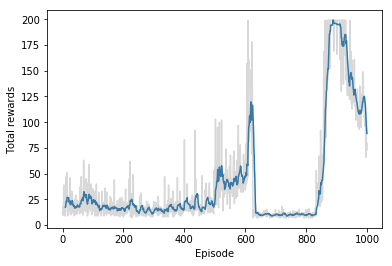

In [50]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'D losses')

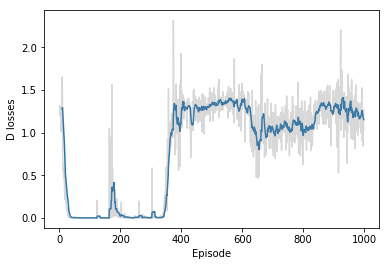

In [51]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'G losses')

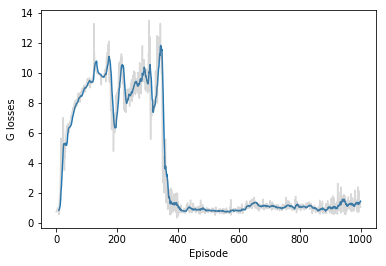

In [52]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'Q losses')

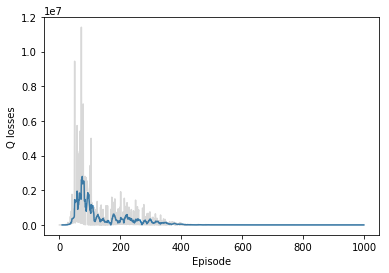

In [53]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

## Testing

Let's checkout how our trained agent plays the game.

In [54]:
test_episodes = 10
test_max_steps = 1000
env.reset()
with tf.Session() as sess:
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    # Save the trained model 
    saver.restore(sess, 'checkpoints/DQAN-cartpole.ckpt')
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/DQAN-cartpole.ckpt


NameError: name 'base' is not defined

In [28]:
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.